# Working with large data volumes

> Authors: Ashley Smith
>
> Abstract: Some strategies for requesting and handling larger data volumes

Note that the code could take a long time to run, so it is better to adjust it for smaller jobs if you are just testing it out.

In [1]:
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

2020-02-17T19:21:13+00:00

CPython 3.7.6
IPython 7.11.1

viresclient 0.5.0
pandas 0.25.3
xarray 0.15.0
matplotlib 3.1.2


In [2]:
from viresclient import SwarmRequest
import datetime as dt
import xarray as xr
import glob

## Set up the request parameters - magnetic data and model evaluations

We fetch the measurements (`F`, `B_NEC`), and model values (named as `F_CHAOS`, `B_NEC_CHAOS`) - here we name the custom model as "CHAOS" but you can call it anything.

It is also possible to fetch data from all satellites at once with `request.set_collection("SW_OPER_MAGA_LR_1B", "SW_OPER_MAGB_LR_1B", ""SW_OPER_MAGC_LR_1B")`, which will be identified in the returned data by the `Spacecraft` column.

In [3]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")  # Swarm Alpha
request.set_products(
    measurements=["F", "B_NEC"],
    # Choose between the full CHAOS model (will be a lot slower - the MMA part could use some optimisation(?))
#     models=["CHAOS = 'CHAOS-6-Core' + 'CHAOS-6-Static' + 'CHAOS-6-MMA-Primary' + 'CHAOS-6-MMA-Secondary'"],
    # ...or just the core part:
    models=["CHAOS = 'CHAOS-Core'"],
    sampling_step="PT1S"
)
# Quality Flags
# https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-1b-product-definitions#label-Flags_F-and-Flags_B-Values-of-MDR_MAG_LR
# NB: will need to do something different for Charlie because the ASM broke so Flags_F are bad
request.set_range_filter("Flags_F", 0, 1)
request.set_range_filter("Flags_B", 0, 1)

## Look at one day to see what the output data will look like

In [4]:
data = request.get_between(
    start_time=dt.datetime(2018,1,1),
    end_time=dt.datetime(2018,1,2)
)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (8.212MB)


In [5]:
data.as_dataframe(expand=True).head()

,Spacecraft,F_CHAOS,F,Latitude,Longitude,Radius,B_NEC_CHAOS_N,B_NEC_CHAOS_E,B_NEC_CHAOS_C,B_NEC_N,B_NEC_E,B_NEC_C
2018-01-01 00:00:00,A,46590.651442,46592.0984,67.633961,171.372832,6808059.52,10359.090249,-153.330860,45424.162520,10359.2446,-187.2981,45425.4040
2018-01-01 00:00:01,A,46576.496034,46578.1323,67.570052,171.389161,6808066.03,10394.356035,-152.358992,45401.587331,10394.1152,-186.2339,45403.1172
2018-01-01 00:00:02,A,46562.259520,46564.0862,67.506140,171.405378,6808072.56,10429.603616,-151.379659,45378.898887,10429.4246,-184.7463,45380.5991
2018-01-01 00:00:03,A,46547.941922,46549.9552,67.442226,171.421486,6808079.11,10464.832613,-150.392871,45356.097248,10464.5537,-183.3768,45358.0147
2018-01-01 00:00:04,A,46533.543452,46535.7412,67.378309,171.437486,6808085.67,10500.042743,-149.398655,45333.182644,10499.3677,-182.4300,45335.4015


In [6]:
data.as_xarray()

<xarray.Dataset>
Dimensions:      (NEC: 3, Timestamp: 84595)
Coordinates:
  * Timestamp    (Timestamp) datetime64[ns] 2018-01-01 ... 2018-01-01T23:59:59
  * NEC          (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft   (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    F            (Timestamp) float64 4.659e+04 4.658e+04 ... 4.706e+04 4.704e+04
    F_CHAOS      (Timestamp) float64 4.659e+04 4.658e+04 ... 4.712e+04 4.71e+04
    Latitude     (Timestamp) float64 67.63 67.57 67.51 ... -81.72 -81.78 -81.84
    Longitude    (Timestamp) float64 171.4 171.4 171.4 ... -164.9 -164.8 -164.7
    B_NEC        (Timestamp, NEC) float64 1.036e+04 -187.3 ... -4.583e+04
    Radius       (Timestamp) float64 6.808e+06 6.808e+06 ... 6.825e+06 6.825e+06
    B_NEC_CHAOS  (Timestamp, NEC) float64 1.036e+04 -153.3 ... -4.592e+04
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20180101T000000_20180101T235959_050...
    MagneticModels:  ["CHAOS = 'CHAOS-Core'(max_degree=20,min_degree=1)"]
    RangeFilters:    ['Flags_B:0,1', 'Flags_F:0,1']

## Three options suggested for how to deal with larger volumes (option 2 is recommended)

### 1. a) Fetch two years of data and save them directly

For this example we simplify the acquired data (lower cadence, fewer measurements)

In [7]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")  # Swarm Alpha
request.set_products(
    measurements=["F"],
    sampling_step="PT5S"
)
# Quality Flags
# https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-1b-product-definitions#label-Flags_F-and-Flags_B-Values-of-MDR_MAG_LR
# NB: will need to do something different for Charlie because the ASM broke so Flags_F are bad
request.set_range_filter("Flags_F", 0, 1)
request.set_range_filter("Flags_B", 0, 1)

The request is automatically split up and sequentially processed.

In [8]:
data = request.get_between(
    start_time=dt.datetime(2014,1,1),
    end_time=dt.datetime(2016,1,1)
)

[1/3] Processing:  100%|██████████|  [ Elapsed: 00:14, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ] (165.873MB)
[2/3] Processing:  100%|██████████|  [ Elapsed: 00:14, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:02, Remaining: 00:00 ] (174.037MB)
[3/3] Processing:  100%|██████████|  [ Elapsed: 00:13, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ] (160.447MB)


`data` is a kind of wrapper around some temporary CDF files (more data -> more files). This means the data is accessible but not yet loaded into memory. When the variable `data` is deleted, or the current program is closed, the files will be removed. `data.contents` is a list of objects which point to each file, and each on-disk filename can be retrieved as below.

Warning: this behaviour is likely to change in the future (an underscore in the name, `_file`, indicates a private variable whose behaviour in the future is not guaranteed).

In [9]:
data.contents[0]._file.name

'/tmp/vires_lx1et8uv'

`data.as_dataframe()` / `data.as_xarray()` will read the files and concatenate them, but will fail if you don't have the memory to load them all simultaneously.

#### Save the files directly

The length of `data.contents` tells us the number of temporary files. Use this to make up some file names to give them.

In [10]:
filenames = [f"testfile_{n:03}.cdf" for n in range(len(data.contents))]
filenames

['testfile_000.cdf', 'testfile_001.cdf', 'testfile_002.cdf']

In [11]:
print(data.to_files.__doc__)

Saves the data to the specified files.

        Only write to file if it does not yet exist, or if overwrite=True.
        Currently handles CSV and CDF formats.

        Args:
            paths (list of str): paths to the files to save as
            overwrite (bool): Will overwrite existing file if True

        


In [12]:
data.to_files(filenames)

Data written to testfile_000.cdf
Data written to testfile_001.cdf
Data written to testfile_002.cdf


From here you may use some other tool to work with the files. I will just remove them now:

In [13]:
!rm testfile_*

### 1. b) Tune the size of each generated file by making multiple requests manually

Generate lists of start and end times to use...

In [14]:
def gen_start_ends(
        start=dt.datetime(2014, 1, 1),
        end=dt.datetime(2014, 2, 1),
        ndays=1):
    delta_t = dt.timedelta(days=ndays)
    start_times = []
    end_times = []
    start_i = start
    end_i = start_i + dt.timedelta(days=1)
    while end_i <= end:
    #     print(start, end)
        start_times.append(start_i)
        end_times.append(end_i)
        start_i, end_i = end_i, end_i + delta_t
    # Append an uneven ending segment if necessary
    if end_times[-1] < end:
        start_times.append(start_i)
        end_times.append(end)
    return start_times, end_times
    
start_times, end_times = gen_start_ends(
    start=dt.datetime(2014, 1, 1),
    end=dt.datetime(2014, 2, 1),
    ndays=1
)
list(zip(start_times, end_times))

[(datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2014, 1, 2, 0, 0)),
 (datetime.datetime(2014, 1, 2, 0, 0), datetime.datetime(2014, 1, 3, 0, 0)),
 (datetime.datetime(2014, 1, 3, 0, 0), datetime.datetime(2014, 1, 4, 0, 0)),
 (datetime.datetime(2014, 1, 4, 0, 0), datetime.datetime(2014, 1, 5, 0, 0)),
 (datetime.datetime(2014, 1, 5, 0, 0), datetime.datetime(2014, 1, 6, 0, 0)),
 (datetime.datetime(2014, 1, 6, 0, 0), datetime.datetime(2014, 1, 7, 0, 0)),
 (datetime.datetime(2014, 1, 7, 0, 0), datetime.datetime(2014, 1, 8, 0, 0)),
 (datetime.datetime(2014, 1, 8, 0, 0), datetime.datetime(2014, 1, 9, 0, 0)),
 (datetime.datetime(2014, 1, 9, 0, 0), datetime.datetime(2014, 1, 10, 0, 0)),
 (datetime.datetime(2014, 1, 10, 0, 0), datetime.datetime(2014, 1, 11, 0, 0)),
 (datetime.datetime(2014, 1, 11, 0, 0), datetime.datetime(2014, 1, 12, 0, 0)),
 (datetime.datetime(2014, 1, 12, 0, 0), datetime.datetime(2014, 1, 13, 0, 0)),
 (datetime.datetime(2014, 1, 13, 0, 0), datetime.datetime(2014, 1, 14

Generate some file names to use

In [15]:
filenames = [f"data_{start.strftime('%Y-%m-%d')}.cdf" for start in start_times]
filenames

['data_2014-01-01.cdf',
 'data_2014-01-02.cdf',
 'data_2014-01-03.cdf',
 'data_2014-01-04.cdf',
 'data_2014-01-05.cdf',
 'data_2014-01-06.cdf',
 'data_2014-01-07.cdf',
 'data_2014-01-08.cdf',
 'data_2014-01-09.cdf',
 'data_2014-01-10.cdf',
 'data_2014-01-11.cdf',
 'data_2014-01-12.cdf',
 'data_2014-01-13.cdf',
 'data_2014-01-14.cdf',
 'data_2014-01-15.cdf',
 'data_2014-01-16.cdf',
 'data_2014-01-17.cdf',
 'data_2014-01-18.cdf',
 'data_2014-01-19.cdf',
 'data_2014-01-20.cdf',
 'data_2014-01-21.cdf',
 'data_2014-01-22.cdf',
 'data_2014-01-23.cdf',
 'data_2014-01-24.cdf',
 'data_2014-01-25.cdf',
 'data_2014-01-26.cdf',
 'data_2014-01-27.cdf',
 'data_2014-01-28.cdf',
 'data_2014-01-29.cdf',
 'data_2014-01-30.cdf',
 'data_2014-01-31.cdf']

Loop through these dates and file names to fetch and save each.

(Here we remove the progress bars with `show_progress=False` just to keep this notebook cleaner - in reality you might want to keep them)

In [16]:
for start, end, filename in zip(start_times, end_times, filenames):
    data = request.get_between(start, end, show_progress=False)
    data.to_file(filename, overwrite=True)

Data written to data_2014-01-01.cdf
Data written to data_2014-01-02.cdf
Data written to data_2014-01-03.cdf
Data written to data_2014-01-04.cdf
Data written to data_2014-01-05.cdf
Data written to data_2014-01-06.cdf
Data written to data_2014-01-07.cdf
Data written to data_2014-01-08.cdf
Data written to data_2014-01-09.cdf
Data written to data_2014-01-10.cdf
Data written to data_2014-01-11.cdf
Data written to data_2014-01-12.cdf
Data written to data_2014-01-13.cdf
Data written to data_2014-01-14.cdf
Data written to data_2014-01-15.cdf
Data written to data_2014-01-16.cdf
Data written to data_2014-01-17.cdf
Data written to data_2014-01-18.cdf
Data written to data_2014-01-19.cdf
Data written to data_2014-01-20.cdf
Data written to data_2014-01-21.cdf
Data written to data_2014-01-22.cdf
Data written to data_2014-01-23.cdf
Data written to data_2014-01-24.cdf
Data written to data_2014-01-25.cdf
Data written to data_2014-01-26.cdf
Data written to data_2014-01-27.cdf
Data written to data_2014-01

In [17]:
!rm data_2014*.cdf

### 2. Use viresclient to translate the data from CDF to xarray then to netCDF - using the chunks defined as above

There are some nicer tools for working with netCDF4/HDF files in Python so this may be preferable. This is also a point at which you may do some pre-processing before saving the files.

In [18]:
start_times, end_times = gen_start_ends(
    start=dt.datetime(2014, 1, 1),
    end=dt.datetime(2014, 2, 1))
filenames_nc = [f"data_{start.strftime('%Y-%m-%d')}.nc" for start in start_times]

for start, end, filename in zip(start_times, end_times, filenames_nc):
    try:
        data = request.get_between(start, end, show_progress=False)
        ds = data.as_xarray()
        print(f"saved {filename}")
    except RuntimeError:
        print(f"No data for {filename} - data not downloaded")
    try:
        ds.to_netcdf(filename)
    except AttributeError:
        print(f"No data for {filename} - file not created")

saved data_2014-01-01.nc
saved data_2014-01-02.nc
saved data_2014-01-03.nc
saved data_2014-01-04.nc
saved data_2014-01-05.nc
saved data_2014-01-06.nc
saved data_2014-01-07.nc
saved data_2014-01-08.nc
saved data_2014-01-09.nc
saved data_2014-01-10.nc
saved data_2014-01-11.nc
saved data_2014-01-12.nc
saved data_2014-01-13.nc
saved data_2014-01-14.nc
saved data_2014-01-15.nc
saved data_2014-01-16.nc
saved data_2014-01-17.nc
saved data_2014-01-18.nc
saved data_2014-01-19.nc
saved data_2014-01-20.nc
saved data_2014-01-21.nc
saved data_2014-01-22.nc
saved data_2014-01-23.nc
saved data_2014-01-24.nc
saved data_2014-01-25.nc
saved data_2014-01-26.nc
saved data_2014-01-27.nc
saved data_2014-01-28.nc
saved data_2014-01-29.nc
saved data_2014-01-30.nc
saved data_2014-01-31.nc


#### Use xarray+dask to lazily load the data

See https://xarray.pydata.org/en/stable/dask.html

Note: there is currently a bug in loading data where the variables in the file are empty (Swarm Alpha had a few problem days in January 2014 - this does not happen often). We can identify these problem files like this:

In [19]:
filenames = glob.glob("data_*.nc")
empty_files = []
for filename in filenames:
    try:
        xr.open_dataset(filename)
    except ValueError:
        empty_files.append(filename)
empty_files

['data_2014-01-06.nc', 'data_2014-01-19.nc', 'data_2014-01-05.nc']

In [20]:
# Remove the problem files above
filenames = [f for f in filenames if f not in empty_files]
filenames.sort()
filenames

['data_2014-01-01.nc',
 'data_2014-01-02.nc',
 'data_2014-01-03.nc',
 'data_2014-01-04.nc',
 'data_2014-01-07.nc',
 'data_2014-01-08.nc',
 'data_2014-01-09.nc',
 'data_2014-01-10.nc',
 'data_2014-01-11.nc',
 'data_2014-01-12.nc',
 'data_2014-01-13.nc',
 'data_2014-01-14.nc',
 'data_2014-01-15.nc',
 'data_2014-01-16.nc',
 'data_2014-01-17.nc',
 'data_2014-01-18.nc',
 'data_2014-01-20.nc',
 'data_2014-01-21.nc',
 'data_2014-01-22.nc',
 'data_2014-01-23.nc',
 'data_2014-01-24.nc',
 'data_2014-01-25.nc',
 'data_2014-01-26.nc',
 'data_2014-01-27.nc',
 'data_2014-01-28.nc',
 'data_2014-01-29.nc',
 'data_2014-01-30.nc',
 'data_2014-01-31.nc']

In [21]:
# ds = xr.open_mfdataset("data_2014*.nc", combine="by_coords")
ds = xr.open_mfdataset(filenames, combine="by_coords")
ds

<xarray.Dataset>
Dimensions:     (Timestamp: 425322)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2014-01-01 ... 2014-01-31T23:59:55
Data variables:
    Spacecraft  (Timestamp) object dask.array<chunksize=(17038,), meta=np.ndarray>
    F           (Timestamp) float64 dask.array<chunksize=(17038,), meta=np.ndarray>
    Latitude    (Timestamp) float64 dask.array<chunksize=(17038,), meta=np.ndarray>
    Longitude   (Timestamp) float64 dask.array<chunksize=(17038,), meta=np.ndarray>
    Radius      (Timestamp) float64 dask.array<chunksize=(17038,), meta=np.ndarray>
Attributes:
    Sources:         SW_OPER_MAGA_LR_1B_20140101T000000_20140101T235959_0505_...
    MagneticModels:  []
    RangeFilters:    ['Flags_B:0,1', 'Flags_F:0,1']

Note: Loading in this way has lost the source information - only the first one has been kept.

In [22]:
ds.Sources

'SW_OPER_MAGA_LR_1B_20140101T000000_20140101T235959_0505_MDR_MAG_LR'

We now have access to the dataset which is stored on disk as multiple files:

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


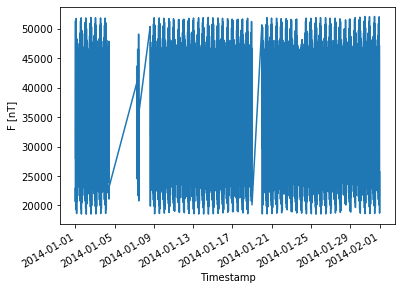

In [23]:
ds["F"].plot();

In [24]:
del ds, data

In [25]:
!rm data_*

### 3. Leave the handling to viresclient and just try to load the full data directly

There are some performance issues here, and if the total size is too big for your machine's memory then it won't be possible. We could make some changes to viresclient in the future to perform the lazy loading as above.

In [26]:
data = request.get_between(
    start_time=dt.datetime(2014,1,1),
    end_time=dt.datetime(2015,1,1)
)

[1/2] Processing:  100%|██████████|  [ Elapsed: 00:14, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ] (165.873MB)
[2/2] Processing:  100%|██████████|  [ Elapsed: 00:07, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (80.035MB)


In [27]:
%%time
ds = data.as_xarray()
ds

CPU times: user 54.5 s, sys: 483 ms, total: 55 s
Wall time: 55.8 s


<xarray.Dataset>
Dimensions:     (Timestamp: 5995185)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2014-01-01 ... 2014-12-31T23:59:55
Data variables:
    Spacecraft  (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    F           (Timestamp) float64 2.287e+04 2.284e+04 ... 4.229e+04 4.216e+04
    Latitude    (Timestamp) float64 -1.229 -1.546 -1.863 ... 52.68 52.36 52.04
    Longitude   (Timestamp) float64 -14.12 -14.12 -14.13 ... -147.2 -147.2
    Radius      (Timestamp) float64 6.878e+06 6.878e+06 ... 6.83e+06 6.83e+06
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20140101T000000_20140101T235959_050...
    MagneticModels:  []
    RangeFilters:    ['Flags_B:0,1', 'Flags_F:0,1']

In [28]:
for i in ds.Sources[:3]:
    print(i)
print("...")
for i in ds.Sources[-3:]:
    print(i)

SW_OPER_MAGA_LR_1B_20140101T000000_20140101T235959_0505_MDR_MAG_LR
SW_OPER_MAGA_LR_1B_20140102T000000_20140102T235959_0505_MDR_MAG_LR
SW_OPER_MAGA_LR_1B_20140103T000000_20140103T235959_0505_MDR_MAG_LR
...
SW_OPER_MAGA_LR_1B_20141229T000000_20141229T235959_0505_MDR_MAG_LR
SW_OPER_MAGA_LR_1B_20141230T000000_20141230T235959_0505_MDR_MAG_LR
SW_OPER_MAGA_LR_1B_20141231T000000_20141231T235959_0505_MDR_MAG_LR


#### It is possible to access each file and load as xarray Dataset (rather than automatically concatenating them all)

In [29]:
data.contents[0].as_xarray()

<xarray.Dataset>
Dimensions:     (Timestamp: 4043952)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2014-01-01 ... 2014-09-07T23:59:55
Data variables:
    Spacecraft  (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    F           (Timestamp) float64 2.287e+04 2.284e+04 ... 4.207e+04 4.22e+04
    Latitude    (Timestamp) float64 -1.229 -1.546 -1.863 ... 54.96 55.28 55.6
    Longitude   (Timestamp) float64 -14.12 -14.12 -14.13 ... -165.2 -165.2
    Radius      (Timestamp) float64 6.878e+06 6.878e+06 ... 6.834e+06 6.834e+06

In [30]:
# %%time
# filenames = [f"testfile_{n:03}.nc" for n in range(len(data.contents))]
# for data_part, filename in zip(data.contents, filenames):
#     data_part.as_xarray().to_netcdf(filename)

In [31]:
# ds = open_mfdataset("testfile*.nc", combine="by_coords")
# ds

In [32]:
# !rm testfile*.nc